## Installing and Importing Necessary Libraries

In [1]:
# Install necessary dependencies
import nltk
!pip install sentence-transformers
!pip install autocorrect
!pip install -U spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# spacy.cli.download("en_core_web_sm")
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 12.8/12.8 MB 12.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AMEY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMEY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMEY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\AMEY\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from autocorrect import Speller
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sentence_transformers.readers import InputExample
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import spacy
import re
nlp = spacy.load('en_core_web_sm')

## Data Preprocessing

In [3]:
# read training dataset
data = pd.read_csv("F2_Claim_Check_Worthiness_train.csv")

In [4]:
data

,tweet,label,id
0,"India's gift of 100,000 COVID-19 vaccines arri...",0,0
1,As part of the ongoing nationwide vaccination ...,0,1
2,"Pleased to receive 50,000 doses of Covid-19 va...",0,2
3,Four former presidents have banded together fo...,0,3
4,WSJ: All three of Russia's main intelligence s...,1,4
...,...,...,...
2117,"Some pearl of Wisdom by your fuckeer ""Bill Gat...",1,2117
2118,Top infectious disease expert Dr. Anthony Fauc...,1,2118
2119,Everyone is looking at Bill Gates for the Coro...,1,2119
2120,The president’s first instinct in response to ...,0,2120


In [5]:
# A funtion for preprocessing the data
def preprocessing(df):
    stop_words = set(stopwords.words("english"))
    preprocessed_df = df.copy()
    preprocessed_df['white_space_removed'] = 0
    preprocessed_df['tokenized_data'] = 0
    preprocessed_df['stopword_removed_data'] = 0
    preprocessed_df['punct_removed_data'] = 0
    preprocessed_df['url_removed_data'] = 0
    preprocessed_df['spelling_checked_data'] = 0
    
    # create object for spelling checking
    spell = Speller(lang='en')

    # iterate over each row of dataset and preprocess data
    for i in range(preprocessed_df.shape[0]):
        # white space removel
        preprocessed_df['white_space_removed'][i] = re.sub("\s+", " ", preprocessed_df.tweet[i])

        # lower casing and tokenization
        lower = preprocessed_df['white_space_removed'][i].lower()
        tokenized_data = word_tokenize(lower)
        preprocessed_df['tokenized_data'][i] = tokenized_data

        # remove stopwords
        stopword_removed_data = [x for x in tokenized_data if x not in stop_words]
        preprocessed_df['stopword_removed_data'][i] = stopword_removed_data 

        # punctuation removel
        punct_removed_data = [x for x in stopword_removed_data if x.isalnum()]
        preprocessed_df['punct_removed_data'][i] = punct_removed_data

        # remove urls and html tags
        urls = re.findall("https?://[a-zA-Z0-9_\?=\@\/#=.~-]+", " ".join(punct_removed_data))
        url_removed_data = [x for x in punct_removed_data if x not in urls]
        preprocessed_df['url_removed_data'][i] = url_removed_data

        # spelling checking
        spelling_checked_data = [spell(x) for x in url_removed_data]
        preprocessed_df['spelling_checked_data'][i] = " ".join(spelling_checked_data)

    return preprocessed_df

In [6]:
df = preprocessing(data)

In [7]:
# rename dataframe
df = df.rename({'spelling_checked_data': 'preprocessed_text'}, axis=1)
df.head()

,tweet,label,id,white_space_removed,tokenized_data,stopword_removed_data,punct_removed_data,url_removed_data,preprocessed_text
0,"India's gift of 100,000 COVID-19 vaccines arri...",0,0,"India's gift of 100,000 COVID-19 vaccines arri...","[india, 's, gift, of, 100,000, covid-19, vacci...","[india, 's, gift, 100,000, covid-19, vaccines,...","[india, gift, vaccines, arrived, barbados, ear...","[india, gift, vaccines, arrived, barbados, ear...",india gift vaccines arrived barbados earlier t...
1,As part of the ongoing nationwide vaccination ...,0,1,As part of the ongoing nationwide vaccination ...,"[as, part, of, the, ongoing, nationwide, vacci...","[part, ongoing, nationwide, vaccination, rollo...","[part, ongoing, nationwide, vaccination, rollo...","[part, ongoing, nationwide, vaccination, rollo...",part ongoing nationwide vaccination rollout se...
2,"Pleased to receive 50,000 doses of Covid-19 va...",0,2,"Pleased to receive 50,000 doses of Covid-19 va...","[pleased, to, receive, 50,000, doses, of, covi...","[pleased, receive, 50,000, doses, covid-19, va...","[pleased, receive, doses, vaccines, india, mor...","[pleased, receive, doses, vaccines, india, mor...",pleased receive doses vaccines india morning g...
3,Four former presidents have banded together fo...,0,3,Four former presidents have banded together fo...,"[four, former, presidents, have, banded, toget...","[four, former, presidents, banded, together, t...","[four, former, presidents, banded, together, t...","[four, former, presidents, banded, together, t...",four former presidents banded together two nat...
4,WSJ: All three of Russia's main intelligence s...,1,4,WSJ: All three of Russia's main intelligence s...,"[wsj, :, all, three, of, russia, 's, main, int...","[wsj, :, three, russia, 's, main, intelligence...","[wsj, three, russia, main, intelligence, servi...","[wsj, three, russia, main, intelligence, servi...",wsj three russia main intelligence services sr...


In [8]:
# extract required feature
df_preprocessed = df[['tweet','label','id','preprocessed_text']]

In [9]:
# store preprocessed data
df_preprocessed.to_csv("preprocessed_train.csv", index=False)

In [10]:
# read train data
df_preprocessed_train = pd.read_csv("preprocessed_train.csv", index_col=False)
df_preprocessed_train.head()

,tweet,label,id,preprocessed_text
0,"India's gift of 100,000 COVID-19 vaccines arri...",0,0,india gift vaccines arrived barbados earlier t...
1,As part of the ongoing nationwide vaccination ...,0,1,part ongoing nationwide vaccination rollout se...
2,"Pleased to receive 50,000 doses of Covid-19 va...",0,2,pleased receive doses vaccines india morning g...
3,Four former presidents have banded together fo...,0,3,four former presidents banded together two nat...
4,WSJ: All three of Russia's main intelligence s...,1,4,wsj three russia main intelligence services sr...


In [11]:
# read test data and store preprocessed test data
df_test=pd.read_csv("F2_Claim_Check_Worthiness_test.csv")
df_test_preprocess = preprocessing(df_test)

df_test_preprocess = df_test_preprocess.rename({'spelling_checked_data': 'preprocessed_text'}, axis=1)
df_test_preprocess_new = df_test_preprocess[['tweet','id','preprocessed_text']]
df_test_preprocess_new.to_csv('preprocessed_test.csv')

# read test data
df_preprocessed_test = pd.read_csv('preprocessed_test.csv')
df_preprocessed_test.head()

,Unnamed: 0,tweet,id,preprocessed_text
0,0,Native American communities have been hit hard...,0,native american communities hit hard thanks in...
1,1,ALERT: CVS Pharmacy is now offering COVID-19 v...,1,alert cvs pharmacy offering vaccines massachus...
2,2,#COVID19 vaccines are an important tool to hel...,2,covid19 vaccines important tool help stop pand...
3,3,Pfizer reports that IRL the vaccine is 97% eff...,3,prize reports irl vaccine 97 effective symptom...
4,4,Vaccines are complex medicines. Europeans can ...,4,vaccines complex medicines european trust vacc...


## Feature Extraction and Dimensionality Reduction

In [12]:
# extract dependency feature
def dep_feature_extraction(sentence):
    docs = nlp(sentence)
    dep_list=[]
    for token in docs:
        dep_list.append(token.dep_)
    dep_feature = " ".join(dep_list)
    return dep_feature

# find pos tag vector of sentences
def get_pos_vector(pos_sentence):
    pos_tags = {'ADJ':0,'ADV':0,'NOUN':0,'PROPN':0,'VERB':0,'NUM':0,'ADP':0,'PRON':0} 
    
    for pos in pos_sentence.split():        
        if pos in pos_tags:
            pos_tags[pos] += 1
            
    return list(pos_tags.values())

# extract pos tag feature
def pos_tag_extraction(sentence):
    docs = nlp(sentence)
    pos_tags_list=[]
    for token in docs:
        pos_tags_list.append(token.pos_)
    pos_tags = " ".join(pos_tags_list)
    return pos_tags

# create list of all unique dependencies in entire data
def get_count_pos_dep_dict(df):
    unique_dep = set()
    for row in df['preprocessed_text']:
        pos_sentence = pos_tag_extraction(row).split()
        dep_sentence = dep_feature_extraction(row).split()
        for pos, dep in zip(pos_sentence, dep_sentence):
            unique_dep.add(pos+"_"+dep)
    return list(unique_dep)

dependency_list = get_count_pos_dep_dict(df_preprocessed_train)

# occurance count of all unique dependencies in entire data    
def get_pos_dep_dict(df):
    unique_dep = {}
    for row in df['preprocessed_text']:
        pos_sentence = pos_tag_extraction(row).split()
        dep_sentence = dep_feature_extraction(row).split()
        for pos, dep in zip(pos_sentence, dep_sentence):
            if (pos+"_"+dep) not in unique_dep:
                unique_dep[(pos+"_"+dep)] = 1
            else:
                unique_dep[(pos+"_"+dep)] += 1            
    return unique_dep

dependency_dict = get_pos_dep_dict(df_preprocessed_train)

# find most important dependency
from collections import Counter

common_dep = Counter(dependency_dict).most_common(15)
important_dep = []

for dep in common_dep:
    important_dep.append(dep[0])
print(important_dep)

['NOUN_compound', 'ADJ_amod', 'PROPN_compound', 'NOUN_dobj', 'NOUN_nsubj', 'VERB_ccomp', 'VERB_ROOT', 'NUM_nummod', 'ADV_advmod', 'PROPN_nsubj', 'NOUN_npadvmod', 'VERB_acl', 'NOUN_nmod', 'VERB_amod', 'VERB_advcl']


In [13]:
# check lengt of most important dependency
len(important_dep)

15

In [14]:
# get dependency vector of depencency sentence
def get_dependency_vector(dep_sentence): 
    pos_tags = {'ADJ':0,'ADV':0,'NOUN':0,'PROPN':0,'NUM':0,} 
    pos_sentence = pos_tag_extraction(dep_sentence).split(" ")
    dep_sentence = dep_feature_extraction(dep_sentence).split(' ')
    sentence_dep_dict = dict.fromkeys(important_dep, 0)
    for pos, dep in zip(pos_sentence, dep_sentence):
      if pos in pos_tags:
        if (pos+"_"+dep) in sentence_dep_dict and (pos+"_"+dep) in important_dep:
            sentence_dep_dict[(pos+"_"+dep)] += 1
    return list(sentence_dep_dict.values())

In [15]:
# apply pca on data
def apply_pca(df, component=190):
  pca = PCA(n_components=component)
  pca_df = pd.DataFrame(pca.fit_transform(df))
  print("Recorded Variance: ", sum(pca.explained_variance_ratio_))
  return pca_df

# find sentence embedding using sentence transformer
def get_sentence_embeddings(df):
  model = SentenceTransformer('all-MiniLM-L6-v2')
  embeddings = []
  for i in range(len(df)):
    embeddings.append(model.encode(df['tweet'][i]))
  sentence_embedding = pd.DataFrame(embeddings)
  return sentence_embedding

# scale the dataframe
def scale_df(df):
  scaler = MinMaxScaler()
  temp = df.copy()
  transformed_data = pd.DataFrame(scaler.fit_transform(temp))
  return transformed_data

# create pipeline for all computation
def processing_pipeline(df):
    # get pos and dep feature
    final_feature = []
    for row in df['preprocessed_text']:
        temp = []
        temp.extend(get_pos_vector(row))
        temp.extend(get_dependency_vector(row))
        final_feature.append(temp)
    df_features = pd.DataFrame(final_feature)

    # sentence embeddings
    sentence_embedding = get_sentence_embeddings(df)
    print(sentence_embedding.shape)

    # merge data
    final_features = pd.concat([df_features, sentence_embedding], axis=1)
    final_features.columns = [list(range(len(df_features.columns) + len(sentence_embedding.columns)))]

    # scale data
    scaled_df = scale_df(final_features)
#     print(scaled_df)

    # apply PCA
    pca_df = apply_pca(scaled_df)

    # return dataframe
    return pca_df

In [16]:
# apply pipeline on preprocessed train data
final_traning_df = processing_pipeline(df_preprocessed_train)
final_traning_df.head()

(2122, 384)
Recorded Variance:  0.9275600204048602


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.199611,-0.160518,-0.817429,-0.280003,-0.309322,0.278933,-0.874784,-0.331610,-0.220336,-0.657431,...,-0.097622,0.035797,0.170165,-0.044704,-0.055563,-0.018431,0.048945,-0.045271,0.005228,0.026277
1,-0.365570,-0.045455,-0.139196,0.577843,0.198076,-0.064297,-0.183888,0.224045,0.458391,-0.404278,...,-0.111668,0.039479,0.041308,0.020128,0.232714,-0.024297,0.105753,0.089437,-0.200582,-0.029214
2,0.136746,-0.625262,-0.932678,0.239444,-0.218699,0.105953,-0.657516,-0.082273,0.110093,-0.682317,...,0.029042,0.076217,-0.002964,-0.036195,-0.142881,-0.060763,0.130682,0.209530,-0.021355,-0.104840
3,0.243228,0.357167,0.083626,-0.432667,-0.325471,0.046425,-0.008460,0.776063,0.070753,-0.076088,...,0.017700,0.064293,-0.060124,0.074071,0.098043,-0.110154,-0.138982,-0.076470,-0.075058,-0.165809
4,0.922625,0.054002,0.731212,-0.669480,0.680888,0.850648,0.248717,0.396017,1.172909,-0.240285,...,-0.054133,0.021500,-0.148623,-0.028792,-0.057443,-0.060097,0.013597,0.101115,0.079914,-0.089905


In [17]:
df_preprocessed_test

,Unnamed: 0,tweet,id,preprocessed_text
0,0,Native American communities have been hit hard...,0,native american communities hit hard thanks in...
1,1,ALERT: CVS Pharmacy is now offering COVID-19 v...,1,alert cvs pharmacy offering vaccines massachus...
2,2,#COVID19 vaccines are an important tool to hel...,2,covid19 vaccines important tool help stop pand...
3,3,Pfizer reports that IRL the vaccine is 97% eff...,3,prize reports irl vaccine 97 effective symptom...
4,4,Vaccines are complex medicines. Europeans can ...,4,vaccines complex medicines european trust vacc...
...,...,...,...,...
190,190,"Today, University of Pittsburgh School of Medi...",190,today university pittsburgh school medicine pi...
191,191,UK: Coronavirus vaccine could be ready by Sept...,191,uk coronavirus vaccine could ready september s...
192,192,Top NIH official Anthony Fauci says coronaviru...,192,top nih official anthony face says coronavirus...
193,193,my flintstones gummies from 15 years ago fight...,193,flintstones mummies 15 years ago fighting coro...


In [18]:
# apply pipeline on preprocessed test data
final_testing_df = processing_pipeline(df_preprocessed_test)
final_testing_df.head()

(195, 384)
Recorded Variance:  0.9995163174286459


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,-1.077578,0.107569,-0.594920,-0.260953,0.524181,0.493353,0.228687,-0.096992,-0.453607,1.379067,...,-0.037561,0.005549,0.072966,0.030451,0.040726,-0.111782,0.070374,-0.027648,0.041469,-0.015871
1,-0.839089,0.805606,0.387870,-0.364074,-0.817118,-0.134789,-0.474676,-0.146516,0.279389,-0.547808,...,0.027057,0.045210,-0.003701,0.070344,0.024888,-0.004183,-0.004034,0.028708,0.055414,-0.001470
2,-0.920084,-0.283874,-0.774438,-0.096526,0.011904,-0.260075,0.993632,0.497925,-0.580150,0.287657,...,0.045989,-0.021812,0.059583,0.045012,0.097849,-0.005392,-0.009161,0.141056,-0.008234,0.051232
3,-0.439589,-0.932350,0.268935,1.031369,0.465010,-0.394454,-1.032244,-0.581948,-0.279736,0.089676,...,0.055738,-0.009921,0.018679,0.007112,-0.021738,0.015178,0.005579,0.022304,-0.023152,-0.014158
4,-0.499760,-1.663349,0.576786,-0.164721,0.103507,0.044870,-0.028237,-0.418249,0.919884,-0.342436,...,-0.028155,0.084591,-0.050236,0.067794,-0.007638,-0.102390,-0.093051,0.054307,-0.036449,-0.059988


In [19]:
# count of labels
print("Label Distributions in Training Dataset")
df_preprocessed_train.label.value_counts()

Label Distributions in Training Dataset


0    1675
1     447
Name: label, dtype: int64

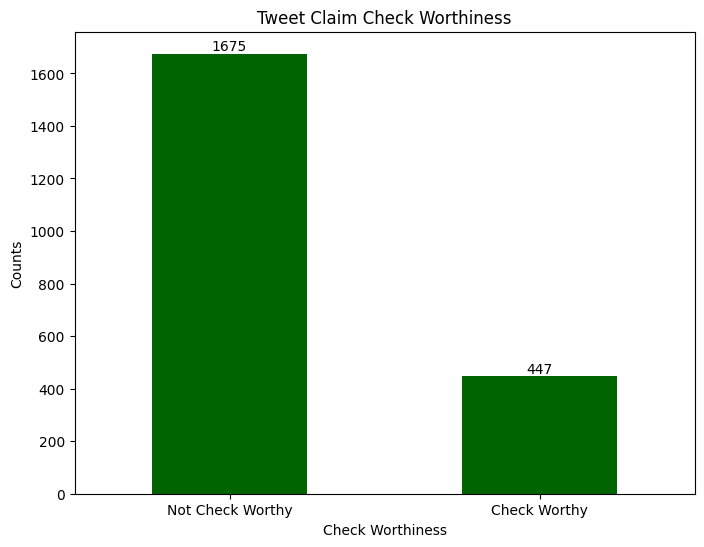

In [20]:
# Plot and visualize the counts
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)

dmap = {0: 'Not Check Worthy', 1: 'Check Worthy'}
ax = (df_preprocessed_train.label.value_counts().rename(dmap)
     .plot.bar(title='Incomplete vs Complete bookings', rot=0, color='darkgreen'))
plt.title("Tweet Claim Check Worthiness")
plt.xlabel("Check Worthiness")
plt.ylabel("Counts")

# Add count labels on top of each bar
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            str(int(bar.get_height())), ha='center', va='bottom')
plt.show()

## Modelling

In [25]:
# split te data into train and validation
y = df_preprocessed_train.label
X_train, X_test, y_train, y_test = train_test_split(final_traning_df, y, train_size=0.7, random_state=42, stratify=y)

In [26]:
df_preprocessed_train.label.value_counts()

0    1675
1     447
Name: label, dtype: int64

In [27]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
1477,-0.152339,-0.670922,0.044087,0.039082,-0.125553,0.415710,0.229749,-0.238396,-0.452795,-0.304531,...,-0.085397,-0.068369,0.096516,-0.030804,-0.005745,0.115104,-0.043993,-0.018030,0.074976,0.009828
697,0.291965,-0.863338,0.030661,-0.661614,0.657842,0.254104,0.003709,-0.343518,0.486537,0.653165,...,0.042076,-0.062768,0.005962,-0.008474,0.156916,-0.104706,0.031212,-0.000427,0.001133,-0.060958
834,-0.467319,-0.124144,-0.584350,0.459143,-0.225861,0.428477,0.307490,0.173332,0.389225,0.097805,...,-0.215009,0.013554,-0.111454,-0.122838,0.078505,-0.130957,0.003491,-0.150708,0.115301,0.035871
930,-0.200916,-0.573894,0.354907,0.098270,-0.182467,0.311093,0.041269,-0.503272,0.520816,0.312392,...,-0.094813,-0.139987,-0.155983,-0.044363,-0.067081,0.117903,0.004390,-0.082609,0.059436,-0.025418
297,-1.013761,0.305535,-0.221792,0.078883,0.015611,0.055211,0.954969,-0.268048,-0.281790,-0.532907,...,0.028624,-0.016640,0.039614,-0.045593,-0.068578,0.081910,-0.019275,-0.068265,0.026217,0.131508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,0.429783,-0.365134,0.038642,-0.105816,0.146849,0.148303,-0.016355,0.065677,0.119168,0.799980,...,0.056411,0.186065,-0.085464,0.043170,0.131963,0.060965,-0.068024,0.037006,0.108523,-0.037756
865,-0.343451,-0.457206,0.663904,0.398069,-0.307887,-0.239333,-0.507095,0.187998,-0.519349,0.222367,...,-0.061198,-0.011216,0.112819,0.117376,0.031016,-0.035598,0.073663,-0.013655,-0.024672,0.082135
2034,-0.206661,0.633388,0.164991,1.207446,-0.098236,0.306581,0.653099,0.262265,-0.278276,-0.164660,...,-0.083943,0.108905,-0.026761,0.014191,0.055535,0.095436,-0.031965,0.137603,0.082136,-0.042290
1113,0.641193,-0.516811,0.367851,-1.024926,0.356748,0.000807,-0.411321,-0.368851,-0.443180,-0.583417,...,0.040135,0.047604,-0.319806,0.051387,-0.067266,-0.027101,-0.065809,0.000534,-0.060033,0.088167


In [28]:
import pickle
from sklearn.metrics import accuracy_score
# train data on SVM model
# model = SVC(C=1, gamma=0.08, class_weight='balanced')
# model.fit(X_train, y_train)

# Save the model to a file
# with open('model_checkpoint.pkl', 'wb') as f:
#     pickle.dump(model, f)
    
# Load the saved model from the file
with open('model_checkpoint.pkl', 'rb') as f:
    model = pickle.load(f)
    
# fit data on model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# test data on model
print("Traning Macro-f1: ", f1_score(y_train, y_pred_train, average='macro'))
print("Validation Macro-f1: ", f1_score(y_test, y_pred_test, average='macro'))

print("\n\nTraning Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_test, y_pred_test))

Traning Macro-f1:  0.8514741390265599
Validation Macro-f1:  0.7151593399672502


Traning Accuracy:  0.8855218855218855
Validation Accuracy:  0.7770800627943485


In [29]:
# compute test labels
y_pred = model.predict(final_testing_df)
len(y_pred)

195

In [30]:
# save test labels with id
ID = [i for i in range(len(y_pred))]
output_df = pd.DataFrame(list(zip(y_pred, ID)), columns=['label', 'id'])
output_df.to_csv("outputs.csv", index=False)

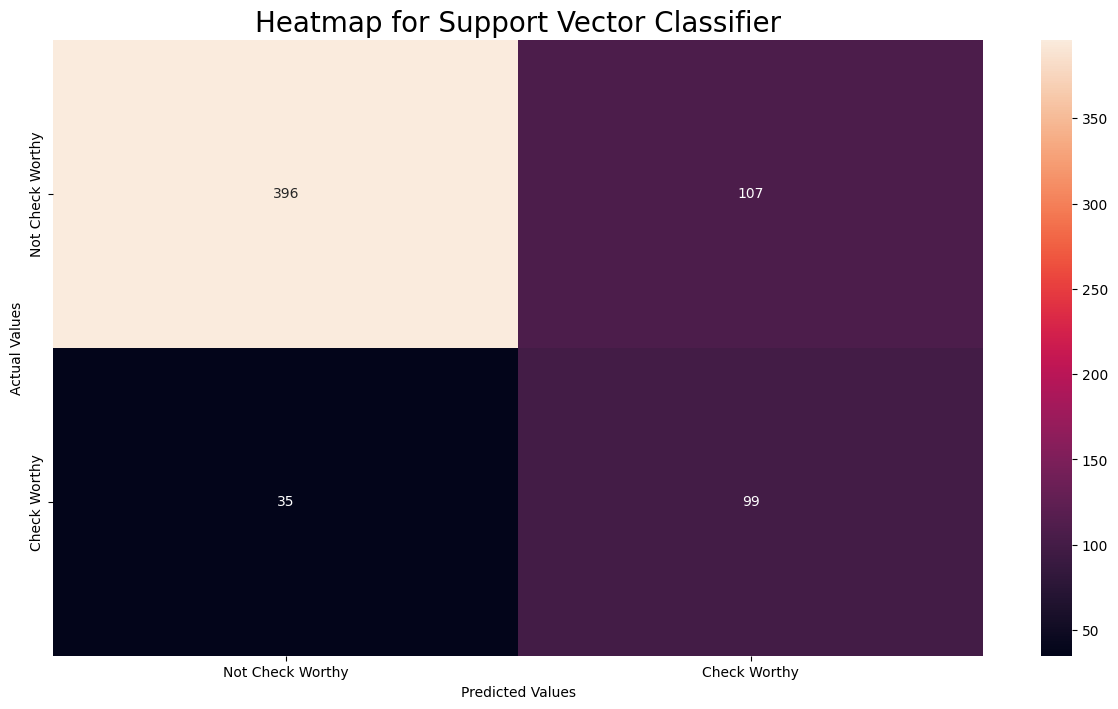

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cf_matrix = confusion_matrix(y_test, y_pred_test)

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,8)) 
# Create the heatmap with whole values
sns.heatmap(cf_matrix, annot=True, fmt='.0f', ax=ax)
# Rename x and y axis labels
ax.set_xticklabels(["Not Check Worthy", "Check Worthy"])
ax.set_yticklabels(["Not Check Worthy", "Check Worthy"])
# Set axis labels
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

ax.set_title('Heatmap for Support Vector Classifier', fontdict = {'fontsize' : 20})
plt.show()

In [33]:
# classification report
print("Classification Report for Validation Set:\n")
print(classification_report(y_test, y_pred_test))

Classification Report for Validation Set:

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       503
           1       0.48      0.74      0.58       134

    accuracy                           0.78       637
   macro avg       0.70      0.76      0.72       637
weighted avg       0.83      0.78      0.79       637



## Testing the system on a new tweet

In [35]:
c = 194
def checkTweet():
    global c
    inp = input("Please paste your tweet here: \n")
    inp_df = pd.DataFrame([[99, inp, 200]], columns=["Unnamed: 0", "tweet", "id"])
    c += 1
    preprocessed_input_df = preprocessing(inp_df)
    preprocessed_input_df = preprocessed_input_df.rename({'spelling_checked_data': 'preprocessed_text'}, axis=1)
    preprocessed_input_df = preprocessed_input_df[['Unnamed: 0', 'tweet','id','preprocessed_text']]
    df_preprocessed_test.loc[len(df_preprocessed_test.index)] = [c, inp, c, preprocessed_input_df["preprocessed_text"][0]]
    # apply pipeline on preprocessed test data
    testing_df = processing_pipeline(df_preprocessed_test)
    y_pred_test = model.predict(testing_df)
    print("\nTweet Claim Check Worthiness => "+dmap[y_pred_test[-1]])
    return "Success"

In [36]:
checkTweet()

Please paste your tweet here: 
All three of Russia's main intelligence services (SVR, FSB, and GRU) ran fake news sites and phony social media accounts to spread misinformation about Pfeizer and Moderna vaccines in an attempt to undermine confidence in them. https://t.co/t3kmCYvBFs via @WSJ
(196, 384)
Recorded Variance:  0.9993969381069857

Tweet Claim Check Worthiness => Check Worthy


'Success'